# SpeechBrain Project

## Introduction

### Context

The concept of EEG-Based Motor Imagery Decoding involves interpreting brain activity to decode intended movements in individuals with limited physical abilities who are afflicted with pathologies such as paralysis or neuromuscular disorders. By capturing electrical signals from the brain using EEG sensors, machine learning models can predict the intended movements based on the recorded signals. Popular models like EEGNET, ShallowConvNET, and EEGConformer are used for this task, with EEGNET often yielding state-of-the-art results.

The aim of this project is to create multiple neural networks to decode Motor Imagery patterns from EEG data and assess their efficacy using the SpeechBrain benchmarking toolkit provided by Ravanelli et al. [1].


### Dataset

The BNCI2014001 dataset, made available through SpeechBrain [1], is employed to train and test the various deep learning models developed for this project.

This dataset includes EEG recordings from 9 subjects engaging in mental simulations of four motor imagery tasks: left hand movement, right hand movement, both feet movement, and tongue movement. Two sessions were completed by each subject on different days, with each session comprising 6 runs separated by brief intervals. Each run consists of 48 trials, resulting in a total of 288 trials per session, or 576 trials per subject.

### Download my models and results for the main model

In [ ]:
%%capture
!git clone https://github.com/quanatr/speechbrain_moabb_project.git

## Main Model Implementation

This model is comprised of three distinct branches, each receiving identical input. Each branch's architecture closely resembles that of the EEGNet model, particularly the one designed and implemented by Ravanelli et al. [1], with variations in kernel size and the number of convolutional filters within the depth-wise and separable convolutional layers.

The main idea behind this model is to have each branch learn different features or representations from the same input data. By having multiple branches, each with its own set of hyperparameters, it is possible that the overall model can capture diverse aspects of the data which could potentially lead to better generalization and overall performance. The outputs of the three branches are then combined (i.e. concatenated) at the fusion layer to give a single prediction.

It is worth noting that the model architecture implemented here is not unprecedented. Prior works by Roots et al. [2] and Altuwaijri et al. [3] have employed similar model architectures for the same classification task of EEG signal decoding. However, preliminary implementations of their models in this particular context and settings did not achieve results as promising as those reported in their respective papers. This finding is all the more surprising considering that Altuwaijri et al. trained and tested their proposed model on the same dataset used in this project [2]. Despite the similarity in architecture, the hyperparameters used in this report are entirely original.

### Download SpeechBrain-MOABB

In [ ]:
%%capture
!pip install --upgrade pip
!git clone https://github.com/speechbrain/benchmarks
%cd /content/benchmarks
!git checkout eeg

!pip install -r /content/benchmarks/benchmarks/MOABB/extra-requirements.txt # Install additional dependencies

### Install the requirements

In [ ]:
%%capture
# Clone SpeechBrain repository (development branch)
%cd /content/
!git clone https://github.com/speechbrain/speechbrain/

# Install required dependencies
!pip install -r /content/speechbrain/requirements.txt

# Install SpeechBrain in editable mode
!pip install -e /content/speechbrain/.

%cd /content/

In [ ]:
%pip install -q mne moabb orion scikit-learn torch torchinfo speechbrain hyperpyyaml braindecode

import mne
import moabb
import orion
import sklearn
import torch
import torchinfo
import speechbrain as sb
from hyperpyyaml import load_hyperpyyaml, dump_hyperpyyaml
import braindecode

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.2/165.2 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.3/239.3 kB 15.7 MB/s eta 0:00:00


<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.pick_types is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.pick_channels_regexp is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.channel_type is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
/usr/local/lib/python3.10/dist-packages/moabb/pipelines/__init__.py:26: ModuleNotFoundError: Tensorflow is not installed. You won't be able to use these MOABB pipelines if you attempt to do so.
  warn(


### Model Architecture

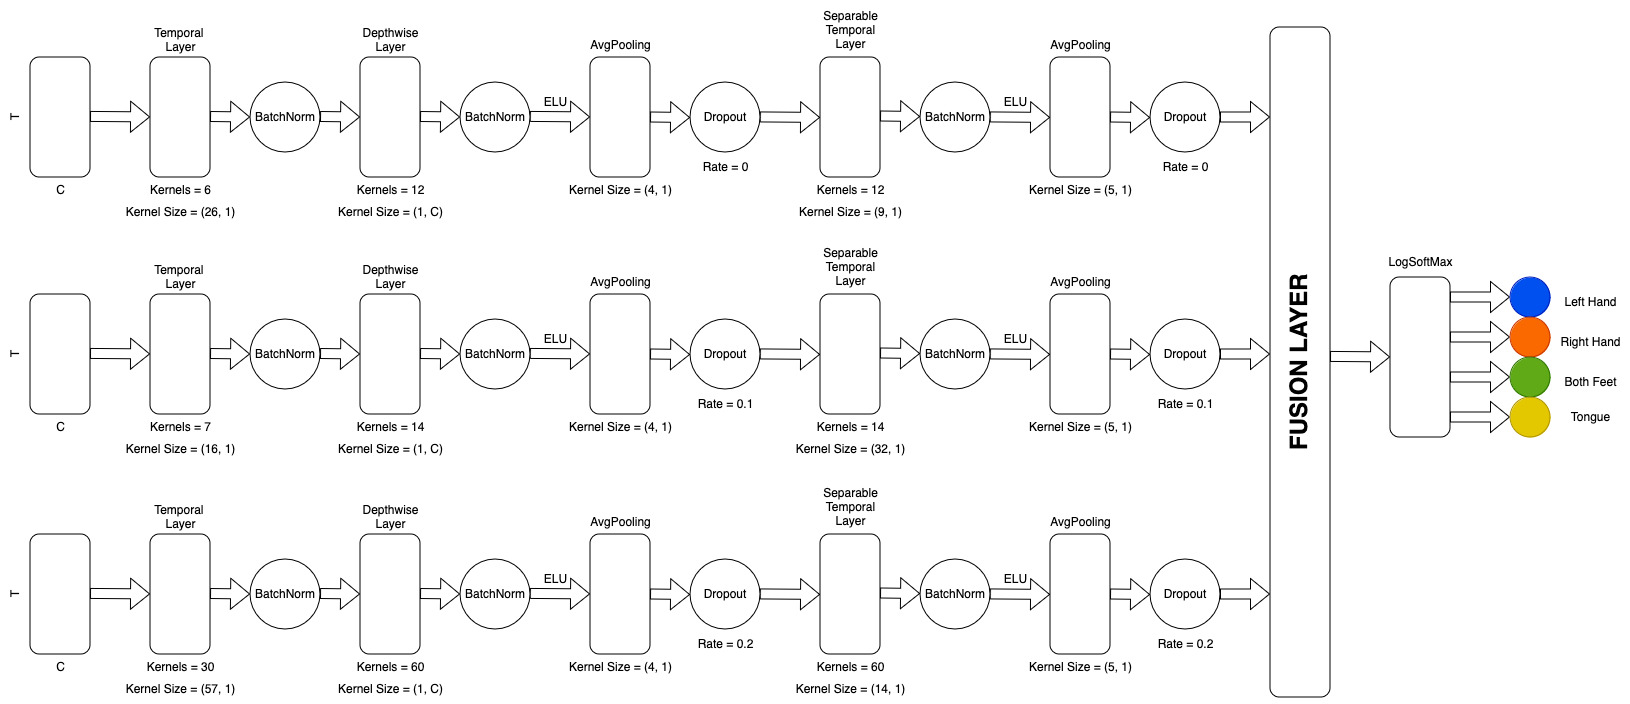

In [ ]:
my_model = """
import torch
import speechbrain as sb
import numpy as np

class EEGNetFusion(torch.nn.Module):
    def __init__(
        self,
        input_shape=None, # (batch_size, time_points, channels(electrodes), num_feature_maps)

        # branch 1
        cnn_temporal_kernels_b1=4,
        cnn_temporal_kernelsize_b1=(16, 1),
        cnn_sep_temporal_kernelsize_b1=(8, 1),
        dropout_b1 = 0,

        # branch 2
        cnn_temporal_kernels_b2=8,
        cnn_temporal_kernelsize_b2=(32, 1),
        cnn_sep_temporal_kernelsize_b2=(16, 1),
        dropout_b2 = 0.1,

        # branch 3
        cnn_temporal_kernels_b3=16,
        cnn_temporal_kernelsize_b3=(64, 1),
        cnn_sep_temporal_kernelsize_b3=(32, 1),
        dropout_b3 = 0.2,

        # common parameters
        cnn_depth_multiplier=2,
        cnn_depth_max_norm=1,
        cnn_depth_pool_size=(4, 1),
        cnn_sep_temporal_multiplier=1,
        # cnn_sep_temporal_kernels = 16,
        cnn_sep_temporal_pool_size=(8, 1),
        cnn_pool_type="avg",
        dense_n_neurons=4,
        dense_max_norm=0.25,
        activation_type='elu',
    ):
        super().__init__()
        if input_shape is None:
            raise ValueError("Must specify input_shape")
        if activation_type == "gelu":
            activation = torch.nn.GELU()
        elif activation_type == "elu":
            activation = torch.nn.ELU()
        elif activation_type == "relu":
            activation = torch.nn.ReLU()
        elif activation_type == "leaky_relu":
            activation = torch.nn.LeakyReLU()
        elif activation_type == "prelu":
            activation = torch.nn.PReLU()
        else:
            raise ValueError("Wrong hidden activation function")
        self.default_sf = 128  # sampling rate of the original publication (Hz)
        T = input_shape[1]
        C = input_shape[2]

        #####################################################
        # BRANCH MODULE 1
        #####################################################
        self.branch_module_1 = torch.nn.Sequential()

        # temporal
        self.branch_module_1.add_module(
            f"temp_conv_b1",
            sb.nnet.CNN.Conv2d(
                in_channels=1,
                out_channels=cnn_temporal_kernels_b1,
                kernel_size=cnn_temporal_kernelsize_b1,
                padding="same",
                padding_mode="constant",
                bias=False,
                swap=True,
            ),
        )

        # temporal batchnorm
        self.branch_module_1.add_module(
            f"temp_bnorm_b1",
            sb.nnet.normalization.BatchNorm2d(
                input_size=cnn_temporal_kernels_b1,
                momentum=0.01,
                affine=True,
            ),
        )

        # num of spatial depthwise filters
        cnn_depth_kernels_b1 = (
            cnn_temporal_kernels_b1 * cnn_depth_multiplier
        )

        # depthwise
        self.branch_module_1.add_module(
            f"depth_conv_b1",
            sb.nnet.CNN.Conv2d(
                in_channels=cnn_temporal_kernels_b1,
                out_channels=cnn_depth_kernels_b1,
                kernel_size=(1, C),
                groups=cnn_temporal_kernels_b1,
                padding="valid",
                bias=False,
                max_norm=cnn_depth_max_norm,
                swap=True,
            ),
        )

        # depthwise batchnorm
        self.branch_module_1.add_module(
            f"depth_bnorm_b1",
            sb.nnet.normalization.BatchNorm2d(
                input_size=cnn_depth_kernels_b1,
                momentum=0.01,
                affine=True,
            ),
        )

        # depthwise activation
        self.branch_module_1.add_module(
            f"depth_act_b1",
            activation
        )

        # depthwise pooling
        self.branch_module_1.add_module(
            f"depth_pool_b1",
            sb.nnet.pooling.Pooling2d(
                pool_type=cnn_pool_type,
                kernel_size=cnn_depth_pool_size,
                stride=cnn_depth_pool_size,
                pool_axis=[1, 2],
            ),
        )

        # depthwise dropout
        self.branch_module_1.add_module(
            f"depth_dropout_b1",
            torch.nn.Dropout(p=dropout_b1),
        )

        # num of separable temporal filters
        cnn_sep_temporal_kernels_b1 = (
            cnn_depth_kernels_b1 * cnn_sep_temporal_multiplier
        )

        # separable temporal (depthwise_component)
        self.branch_module_1.add_module(
            f"sep_temp_depth_conv_b1",
            sb.nnet.CNN.Conv2d(
                in_channels=cnn_depth_kernels_b1,
                out_channels=cnn_depth_kernels_b1,
                kernel_size=cnn_sep_temporal_kernelsize_b1,
                groups=cnn_depth_kernels_b1,
                padding="same",
                padding_mode="constant",
                bias=False,
                swap=True,
            ),
        )

        # separable temporal (pointwise_component)
        self.branch_module_1.add_module(
            f"sep_temp_point_conv_b1",
            sb.nnet.CNN.Conv2d(
                in_channels=cnn_depth_kernels_b1,
                out_channels=cnn_sep_temporal_kernels_b1,
                kernel_size=(1, 1),
                padding="valid",
                bias=False,
                swap=True,
            ),
        )

        # seprarable temporal batchnorm
        self.branch_module_1.add_module(
            f"sep_temp_bnorm_b1",
            sb.nnet.normalization.BatchNorm2d(
                input_size=cnn_sep_temporal_kernels_b1,
                momentum=0.01,
                affine=True,
            ),
        )

        # separable temporal activation
        self.branch_module_1.add_module(
            f"sep_temp_act_b1",
            activation
        )

        # seperable temporal pooling
        self.branch_module_1.add_module(
            f"sep_temp_pool_b1",
            sb.nnet.pooling.Pooling2d(
                pool_type=cnn_pool_type,
                kernel_size=cnn_sep_temporal_pool_size,
                stride=cnn_sep_temporal_pool_size,
                pool_axis=[1, 2],
            ),
        )

        # separable temporal dropout
        self.branch_module_1.add_module(
            f"sep_temp_dropout_b1",
            torch.nn.Dropout(p=dropout_b1),
        )

        # flatten
        self.branch_module_1.add_module(
            f"flatten_b1",
            torch.nn.Flatten(),
        )

        #####################################################
        # BRANCH MODULE 2
        #####################################################
        self.branch_module_2 = torch.nn.Sequential()

        # temporal
        self.branch_module_2.add_module(
            f"temp_conv_b2",
            sb.nnet.CNN.Conv2d(
                in_channels=1,
                out_channels=cnn_temporal_kernels_b2,
                kernel_size=cnn_temporal_kernelsize_b2,
                padding="same",
                padding_mode="constant",
                bias=False,
                swap=True,
            ),
        )

        # temporal batchnorm
        self.branch_module_2.add_module(
            f"temp_bnorm_b2",
            sb.nnet.normalization.BatchNorm2d(
                input_size=cnn_temporal_kernels_b2,
                momentum=0.01,
                affine=True,
            ),
        )

        # num of spatial depthwise filters
        cnn_depth_kernels_b2 = (
            cnn_temporal_kernels_b2 * cnn_depth_multiplier
        )

        # depthwise
        self.branch_module_2.add_module(
            f"depth_conv_b2",
            sb.nnet.CNN.Conv2d(
                in_channels=cnn_temporal_kernels_b2,
                out_channels=cnn_depth_kernels_b2,
                kernel_size=(1, C),
                groups=cnn_temporal_kernels_b2,
                padding="valid",
                bias=False,
                max_norm=cnn_depth_max_norm,
                swap=True,
            ),
        )

        # depthwise batchnorm
        self.branch_module_2.add_module(
            f"depth_bnorm_b2",
            sb.nnet.normalization.BatchNorm2d(
                input_size=cnn_depth_kernels_b2,
                momentum=0.01,
                affine=True,
            ),
        )

        # depthwise activation
        self.branch_module_2.add_module(
            f"depth_act_b2",
            activation
        )

        # depthwise pooling
        self.branch_module_2.add_module(
            f"depth_pool_b2",
            sb.nnet.pooling.Pooling2d(
                pool_type=cnn_pool_type,
                kernel_size=cnn_depth_pool_size,
                stride=cnn_depth_pool_size,
                pool_axis=[1, 2],
            ),
        )

        # depthwise dropout
        self.branch_module_2.add_module(
            f"depth_dropout_b2",
            torch.nn.Dropout(p=dropout_b2),
        )

        # num of separable temporal filters
        cnn_sep_temporal_kernels_b2 = (
            cnn_depth_kernels_b2 * cnn_sep_temporal_multiplier
        )

        # separable temporal (depthwise_component)
        self.branch_module_2.add_module(
            f"sep_temp_depth_conv_b2",
            sb.nnet.CNN.Conv2d(
                in_channels=cnn_depth_kernels_b2,
                out_channels=cnn_depth_kernels_b2,
                kernel_size=cnn_sep_temporal_kernelsize_b2,
                groups=cnn_depth_kernels_b2,
                padding="same",
                padding_mode="constant",
                bias=False,
                swap=True,
            ),
        )

        # separable temporal (pointwise_component)
        self.branch_module_2.add_module(
            f"sep_temp_point_conv_b2",
            sb.nnet.CNN.Conv2d(
                in_channels=cnn_depth_kernels_b2,
                out_channels=cnn_sep_temporal_kernels_b2,
                kernel_size=(1, 1),
                padding="valid",
                bias=False,
                swap=True,
            ),
        )

        # seprarable temporal batchnorm
        self.branch_module_2.add_module(
            f"sep_temp_bnorm_b2",
            sb.nnet.normalization.BatchNorm2d(
                input_size=cnn_sep_temporal_kernels_b2,
                momentum=0.01,
                affine=True,
            ),
        )

        # separable temporal activation
        self.branch_module_2.add_module(
            f"sep_temp_act_b2",
            activation
        )

        # seperable temporal pooling
        self.branch_module_2.add_module(
            f"sep_temp_pool_b2",
            sb.nnet.pooling.Pooling2d(
                pool_type=cnn_pool_type,
                kernel_size=cnn_sep_temporal_pool_size,
                stride=cnn_sep_temporal_pool_size,
                pool_axis=[1, 2],
            ),
        )

        # separable temporal dropout
        self.branch_module_2.add_module(
            f"sep_temp_dropout_b2",
            torch.nn.Dropout(p=dropout_b2),
        )

        # flatten
        self.branch_module_2.add_module(
            f"flatten_b2",
            torch.nn.Flatten(),
        )

        #####################################################
        # BRANCH MODULE 3
        #####################################################
        self.branch_module_3 = torch.nn.Sequential()

        # temporal
        self.branch_module_3.add_module(
            f"temp_conv_b3",
            sb.nnet.CNN.Conv2d(
                in_channels=1,
                out_channels=cnn_temporal_kernels_b3,
                kernel_size=cnn_temporal_kernelsize_b3,
                padding="same",
                padding_mode="constant",
                bias=False,
                swap=True,
            ),
        )

        # temporal batchnorm
        self.branch_module_3.add_module(
            f"temp_bnorm_b3",
            sb.nnet.normalization.BatchNorm2d(
                input_size=cnn_temporal_kernels_b3,
                momentum=0.01,
                affine=True,
            ),
        )

        # num of spatial depthwise filters
        cnn_depth_kernels_b3 = (
            cnn_temporal_kernels_b3 * cnn_depth_multiplier
        )

        # depthwise
        self.branch_module_3.add_module(
            f"depth_conv_b3",
            sb.nnet.CNN.Conv2d(
                in_channels=cnn_temporal_kernels_b3,
                out_channels=cnn_depth_kernels_b3,
                kernel_size=(1, C),
                groups=cnn_temporal_kernels_b3,
                padding="valid",
                bias=False,
                max_norm=cnn_depth_max_norm,
                swap=True,
            ),
        )

        # depthwise batchnorm
        self.branch_module_3.add_module(
            f"depth_bnorm_b3",
            sb.nnet.normalization.BatchNorm2d(
                input_size=cnn_depth_kernels_b3,
                momentum=0.01,
                affine=True,
            ),
        )

        # depthwise activation
        self.branch_module_3.add_module(
            f"depth_act_b3",
            activation
        )

        # depthwise pooling
        self.branch_module_3.add_module(
            f"depth_pool_b3",
            sb.nnet.pooling.Pooling2d(
                pool_type=cnn_pool_type,
                kernel_size=cnn_depth_pool_size,
                stride=cnn_depth_pool_size,
                pool_axis=[1, 2],
            ),
        )

        # depthwise dropout
        self.branch_module_3.add_module(
            f"depth_dropout_b3",
            torch.nn.Dropout(p=dropout_b3),
        )

        # num of separable temporal filters
        cnn_sep_temporal_kernels_b3 = (
            cnn_depth_kernels_b3 * cnn_sep_temporal_multiplier
        )

        # separable temporal (depthwise_component)
        self.branch_module_3.add_module(
            f"sep_temp_depth_conv_b3",
            sb.nnet.CNN.Conv2d(
                in_channels=cnn_depth_kernels_b3,
                out_channels=cnn_depth_kernels_b3,
                kernel_size=cnn_sep_temporal_kernelsize_b3,
                groups=cnn_depth_kernels_b3,
                padding="same",
                padding_mode="constant",
                bias=False,
                swap=True,
            ),
        )

        # separable temporal (pointwise_component)
        self.branch_module_3.add_module(
            f"sep_temp_point_conv_b3",
            sb.nnet.CNN.Conv2d(
                in_channels=cnn_depth_kernels_b3,
                out_channels=cnn_sep_temporal_kernels_b3,
                kernel_size=(1, 1),
                padding="valid",
                bias=False,
                swap=True,
            ),
        )

        # seprarable temporal batchnorm
        self.branch_module_3.add_module(
            f"sep_temp_bnorm_b3",
            sb.nnet.normalization.BatchNorm2d(
                input_size=cnn_sep_temporal_kernels_b3,
                momentum=0.01,
                affine=True,
            ),
        )

        # separable temporal activation
        self.branch_module_3.add_module(
            f"sep_temp_act_b3",
            activation
        )

        # seperable temporal pooling
        self.branch_module_3.add_module(
            f"sep_temp_pool_b3",
            sb.nnet.pooling.Pooling2d(
                pool_type=cnn_pool_type,
                kernel_size=cnn_sep_temporal_pool_size,
                stride=cnn_sep_temporal_pool_size,
                pool_axis=[1, 2],
            ),
        )

        # separable temporal dropout
        self.branch_module_3.add_module(
            f"sep_temp_dropout_b3",
            torch.nn.Dropout(p=dropout_b3),
        )

        # flatten
        self.branch_module_3.add_module(
            f"flatten_b3",
            torch.nn.Flatten(),
        )

        #####################################################
        # DENSE MODULE
        #####################################################
        sample_input = (
            torch.ones((1,) + tuple(input_shape[1:-1]) + (1,))
        )

        # fusion
        branch_outputs = []
        output_b1 = self.branch_module_1(sample_input)
        branch_outputs.append(output_b1)
        output_b2 = self.branch_module_2(sample_input)
        branch_outputs.append(output_b2)
        output_b3 = self.branch_module_3(sample_input)
        branch_outputs.append(output_b3)
        merge = torch.cat(branch_outputs, dim=1)

        # Shape of intermediate feature map
        dense_input_size = self._num_flat_features(merge)

        self.dense_module = torch.nn.Sequential()

        # flatten
        self.dense_module.add_module(
            "flatten",
            torch.nn.Flatten(),
        )

        # linear
        self.dense_module.add_module(
            "fc_out",
            sb.nnet.linear.Linear(
                input_size=dense_input_size,
                n_neurons=dense_n_neurons,
                max_norm=dense_max_norm,)
        )

        # final activation
        self.dense_module.add_module("act_out", torch.nn.LogSoftmax(dim=1))

    def _num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

    def forward(self, x):
        # group all branch outputs
        branch_outputs = []
        x_1 = self.branch_module_1(x)
        branch_outputs.append(x_1)
        x_2 = self.branch_module_2(x)
        branch_outputs.append(x_2)
        x_3 = self.branch_module_3(x)
        branch_outputs.append(x_3)

        # fusion
        merge = torch.cat(branch_outputs, dim=1)

        # dense module
        x = self.dense_module(merge)
        return x
"""

In [ ]:
# save the model into the models folder
f = open('/content/benchmarks/benchmarks/MOABB/models/MyModel.py', "w")
f.write(my_model)
f.close()

### YAML setup

In [ ]:
hparams = """
# TUNED HPARS
# DATASET HPARS
# band-pass filtering cut-off frequencies
fmin: 0.18 # @orion_step1: --fmin~"uniform(0.1, 5, precision=2)"
fmax: 21.9 # @orion_step1: --fmax~"uniform(20.0, 50.0, precision=3)"
# tmin, tmax respect to stimulus onset that define the interval attribute of the dataset class
# trial begins (0 s), cue (2 s, 1.25 s long); each trial is 6 s long
# dataset interval starts from 2
# -->tmin tmax are referred to this start value (e.g., tmin=0.5 corresponds to 2.5 s)
tmin: 0.
tmax: 4.0 # @orion_step1: --tmax~"uniform(1.0, 4.0, precision=2)"
# number of steps used when selecting adjacent channels from a seed channel (default at Cz)
n_steps_channel_selection: 3 # @orion_step1: --n_steps_channel_selection~"uniform(1, 3,discrete=True)"
# We here specify how to perfom test:
# - If test_with: 'last' we perform test with the latest model.
# - if test_with: 'best, we perform test with the best model (according to the metric specified in test_key)
# The variable avg_models can be used to average the parameters of the last (or best) N saved models before testing.
# This can have a regularization effect. If avg_models: 1, the last (or best) model is used directly.
test_with: 'best' # @orio_step1: --test_with~"choices(['last', 'best'])"
test_key: "acc" # Possible opts: "loss", "f1", "auc", "acc"

# TRAINING HPARS
# checkpoints to average
avg_models: 1 # @orion_step1: --avg_models~"uniform(1, 15,discrete=True)"
number_of_epochs: 468 # @orion_step1: --number_of_epochs~"uniform(250, 1000, discrete=True)"
lr: 0.005 # @orion_step1: --lr~"choices([0.01, 0.005, 0.001, 0.0005, 0.0001])"
batch_size_exponent: 6 # tuned

# DATA AUGMENTATION
# cutcat (disabled when min_num_segments=max_num_segments=1)
max_num_segments: 3 # @orion_step2: --max_num_segments~"uniform(2, 6, discrete=True)"
cutcat: !new:speechbrain.augment.time_domain.CutCat
    min_num_segments: 2
    max_num_segments: !ref <max_num_segments>
# random amplitude gain between 0.5-1.5 uV (disabled when amp_delta=0.)
amp_delta: 0.05499 # @orion_step2: --amp_delta~"uniform(0.0, 0.5)"
# random shifts between -300 ms to 300 ms (disabled when shift_delta=0.)
shift_delta_: 1 # orion_step2: --shift_delta_~"uniform(0, 25, discrete=True)"
# injection of gaussian white noise
snr_white_low: 10.0 # @orion_step2: --snr_white_low~"uniform(0.0, 15, precision=2)"
snr_white_delta: 8.33 # @orion_step2: --snr_white_delta~"uniform(5.0, 20.0, precision=3)"
# pipeline
repeat_augment: 1 # @orion_step1: --repeat_augment 0
augment: !new:speechbrain.augment.augmenter.Augmenter
    parallel_augment: True
    concat_original: True
    parallel_augment_fixed_bs: True
    repeat_augment: !ref <repeat_augment>
    shuffle_augmentations: True
    min_augmentations: 4
    max_augmentations: 4
    augmentations: [
        !ref <cutcat>,
        !ref <rand_amp>,
        !ref <time_shift>,
        !ref <add_noise_white>]

# MODEL
# branch 1
cnn_temporal_kernels_b1: 6 # @orion_step1: --cnn_temporal_kernels_b1~"uniform(2, 8, discrete=True)"
cnn_temporal_kernelsize_b1: 26 # @orion_step1: --cnn_temporal_kernelsize_b1~"uniform(8, 32, discrete=True)"
cnn_sep_temporal_kernelsize_b1: 9 # @orion_step1: --cnn_sep_temporal_kernelsize_b1~"uniform(8, 32, discrete=True)"
dropout_b1 : 0. # @orion_step1: --dropout_b1~"uniform(0.0, 0.5)"
# branch 2
cnn_temporal_kernels_b2: 7 # @orion_step1: --cnn_temporal_kernels_b2~"uniform(4, 16, discrete=True)"
cnn_temporal_kernelsize_b2: 16 # @orion_step1: --cnn_temporal_kernelsize_b2~"uniform(16, 64, discrete=True)"
cnn_sep_temporal_kernelsize_b2: 32 # @orion_step1: --cnn_sep_temporal_kernelsize_b2~"uniform(8, 32, discrete=True)"
dropout_b2 : 0.1 # @orion_step1: --dropout_b2~"uniform(0.0, 0.5)"
# branch 3
cnn_temporal_kernels_b3: 30 # @orion_step1: --cnn_temporal_kernels_b3~"uniform(8, 32, discrete=True)"
cnn_temporal_kernelsize_b3: 57 # @orion_step1: --cnn_temporal_kernelsize_b3~"uniform(32, 128, discrete=True)"
cnn_sep_temporal_kernelsize_b3: 14 # @orion_step1: --cnn_sep_temporal_kernelsize_b3~"uniform(8, 32, discrete=True)"
dropout_b3 : 0.2 # @orion_step1: --dropout_b3~"uniform(0.0, 0.5)"
# common parameters
cnn_depth_multiplier: 2
cnn_depth_max_norm: 1
cnn_depth_pool_size: 4
cnn_sep_temporal_multiplier: 1
cnn_sep_temporal_pool_size: 5 # @orion_step1: --cnn_sep_temporal_pool_size~"uniform(1, 8, discrete=True)"
cnn_pool_type: "avg"
dense_n_neurons: 4
dense_max_norm: 0.25
activation_type: 'elu'

##############################################################################################################
# OTHER HPARS
seed: 1234
__set_torchseed: !apply:torch.manual_seed [!ref <seed>]

# DIRECTORIES
data_folder: !PLACEHOLDER  #'/path/to/dataset'. The dataset will be automatically downloaded in this folder
cached_data_folder: !PLACEHOLDER #'path/to/pickled/dataset'
output_folder: !PLACEHOLDER #'path/to/results'

# DATASET HPARS
# Defining the MOABB dataset.
dataset: !new:moabb.datasets.BNCI2014001
save_prepared_dataset: True # set to True if you want to save the prepared dataset as a pkl file to load and use afterwards
data_iterator_name: !PLACEHOLDER
target_subject_idx: !PLACEHOLDER
target_session_idx: !PLACEHOLDER
events_to_load: null # all events will be loaded
original_sample_rate: 250 # Original sampling rate provided by dataset authors
sample_rate: 125 # Target sampling rate (Hz)
n_classes: 4
T: !apply:math.ceil
    - !ref <sample_rate> * (<tmax> - <tmin>)
C: 22

# METRICS
f1: !name:sklearn.metrics.f1_score
    average: 'macro'
acc: !name:sklearn.metrics.balanced_accuracy_score
cm: !name:sklearn.metrics.confusion_matrix
metrics:
    f1: !ref <f1>
    acc: !ref <acc>
    cm: !ref <cm>

# TRAINING HPARS
n_train_examples: 100  # it will be replaced in the train script
# Learning rate scheduling (cyclic learning rate is used here)
max_lr: !ref <lr> # Upper bound of the cycle (max value of the lr)
base_lr: 0.00000001 # Lower bound in the cycle (min value of the lr)
step_size_multiplier: 5 #from 2 to 8
step_size: !apply:round
    - !ref <step_size_multiplier> * <n_train_examples> / <batch_size>
lr_annealing: !new:speechbrain.nnet.schedulers.CyclicLRScheduler
    base_lr: !ref <base_lr>
    max_lr: !ref <max_lr>
    step_size: !ref <step_size>
label_smoothing: 0.0
loss: !name:speechbrain.nnet.losses.nll_loss
    label_smoothing: !ref <label_smoothing>
optimizer: !name:torch.optim.AdamW
    lr: !ref <lr>
epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter  # epoch counter
    limit: !ref <number_of_epochs>
batch_size: !ref 2 ** <batch_size_exponent>
valid_ratio: 0.2

# DATA AUGMENTATION
rand_amp: !new:speechbrain.augment.time_domain.RandAmp
    amp_low: !ref 1 - <amp_delta>
    amp_high: !ref 1 + <amp_delta>
shift_delta: !ref 1e-2 * <shift_delta_> # 0.250 # 0.-0.25 with steps of 0.01
min_shift: !apply:math.floor
    - !ref 0 - <sample_rate> * <shift_delta>
max_shift: !apply:math.floor
    - !ref 0 + <sample_rate> * <shift_delta>
time_shift: !new:speechbrain.augment.freq_domain.RandomShift
    min_shift: !ref <min_shift>
    max_shift: !ref <max_shift>
    dim: 1
snr_white_high: !ref <snr_white_low> + <snr_white_delta>
add_noise_white: !new:speechbrain.augment.time_domain.AddNoise
    snr_low: !ref <snr_white_low>
    snr_high: !ref <snr_white_high>

# DATA NORMALIZATION
dims_to_normalize: 1 # 1 (time) or 2 (EEG channels)
normalize: !name:speechbrain.processing.signal_processing.mean_std_norm
    dims: !ref <dims_to_normalize>

# MODEL
input_shape: [null, !ref <T>, !ref <C>, null]

model: !new:models.MyModel.EEGNetFusion
    input_shape: !ref <input_shape>
    # branch 1
    cnn_temporal_kernels_b1: !ref <cnn_temporal_kernels_b1>
    cnn_temporal_kernelsize_b1: [!ref <cnn_temporal_kernelsize_b1>, 1]
    cnn_sep_temporal_kernelsize_b1: [!ref <cnn_sep_temporal_kernelsize_b1>, 1]
    dropout_b1: !ref <dropout_b1>
    # branch 2
    cnn_temporal_kernels_b2: !ref <cnn_temporal_kernels_b2>
    cnn_temporal_kernelsize_b2: [!ref <cnn_temporal_kernelsize_b2>, 1]
    cnn_sep_temporal_kernelsize_b2: [!ref <cnn_sep_temporal_kernelsize_b2>, 1]
    dropout_b2: !ref <dropout_b2>
    # branch 3
    cnn_temporal_kernels_b3: !ref <cnn_temporal_kernels_b3>
    cnn_temporal_kernelsize_b3: [!ref <cnn_temporal_kernelsize_b3>, 1]
    cnn_sep_temporal_kernelsize_b3: [!ref <cnn_sep_temporal_kernelsize_b3>, 1]
    dropout_b3: !ref <dropout_b3>
    # common parameters
    cnn_depth_multiplier: !ref <cnn_depth_multiplier>
    cnn_depth_max_norm: !ref <cnn_depth_max_norm>
    cnn_depth_pool_size: [!ref <cnn_depth_pool_size>, 1]
    cnn_sep_temporal_multiplier: !ref <cnn_sep_temporal_multiplier>
    cnn_sep_temporal_pool_size: [!ref <cnn_sep_temporal_pool_size>, 1]
    cnn_pool_type: !ref <cnn_pool_type>
    dense_n_neurons: !ref <dense_n_neurons>
    dense_max_norm: !ref <dense_max_norm>
    activation_type: !ref <activation_type>
"""

In [ ]:
# Save the yaml file on disk
f = open('/content/hyperparams.yaml', "w")
f.write(hparams)
f.close()

### Train the model on a single cross-validation fold

In [ ]:
%cd /content/benchmarks/benchmarks/MOABB/

!python train.py /content/hyperparams.yaml \
--data_folder '/content/data/BNCI2014001' \
--cached_data_folder '/content/data' \
--output_folder '/content/results/single-fold-example/BNCI2014001' \
--data_iterator_name 'leave-one-session-out' \
--target_subject_idx 8 \
--target_session_idx 1 \
--number_of_epochs 1000 \
--device 'cuda' # Switch to cuda for a speed up.

/content/benchmarks/benchmarks/MOABB
<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.pick_types is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.pick_channels_regexp is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.channel_type is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
2024-04-25 16:12:11.253412: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-25 16:12:11.253508: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unab

In [ ]:
%cd /content/benchmarks/benchmarks/MOABB/

!python train.py /content/hyperparams.yaml \
--data_folder '/content/data/BNCI2014001' \
--cached_data_folder '/content/data' \
--output_folder '/content/results/single-fold-example/BNCI2014001' \
--data_iterator_name 'leave-one-session-out' \
--target_subject_idx 1 \
--target_session_idx 1 \
--number_of_epochs 1000 \
--device 'cuda' # Switch to cuda for a speed up.


/content/benchmarks/benchmarks/MOABB
<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.pick_types is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.pick_channels_regexp is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.channel_type is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
2024-04-25 16:14:12.956882: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-25 16:14:12.956949: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unab

### Complete experiment for all 9 subjects



In [ ]:
%cd /content/benchmarks/benchmarks/MOABB/

!./run_experiments.sh --hparams /content/hyperparams.yaml \
--data_folder '/content/data/BNCI2014001'\
--cached_data_folder '/content/data' \
--output_folder '/content/results/full-experiment/BNCI2014001' \
--nsbj 9 --nsess 2 --nruns 10 --train_mode 'leave-one-session-out' \
--number_of_epochs 468 \
--device 'cuda'

Streaming output truncated to the last 5000 lines.
speechbrain.nnet.schedulers - Changing lr from 0.0033 to 0.0036
speechbrain.utils.train_logger - epoch: 138, lr: 3.06e-03 - train loss: 3.82e-02 - valid loss: 3.83e-01, valid f1: 8.40e-01, valid acc: 8.39e-01, valid cm: [[12  1  1  0]
 [ 0 12  1  1]
 [ 1  2 11  0]
 [ 1  1  0 12]]
speechbrain.utils.epoch_loop - Going into epoch 139
speechbrain.nnet.schedulers - Changing lr from 0.0044 to 0.0047
speechbrain.utils.train_logger - epoch: 139, lr: 4.17e-03 - train loss: 5.14e-02 - valid loss: 3.87e-01, valid f1: 8.75e-01, valid acc: 8.75e-01, valid cm: [[13  0  1  0]
 [ 0 12  1  1]
 [ 1  1 12  0]
 [ 1  1  0 12]]
speechbrain.utils.epoch_loop - Going into epoch 140
speechbrain.nnet.schedulers - Changing lr from 0.0044 to 0.0042
speechbrain.utils.train_logger - epoch: 140, lr: 4.72e-03 - train loss: 5.53e-02 - valid loss: 4.40e-01, valid f1: 8.42e-01, valid acc: 8.39e-01, valid cm: [[13  1  0  0]
 [ 0 12  1  1]
 [ 0  4 10  0]
 [ 1  1  0 12]]
sp

### Hyperparameters tuning

In [ ]:
%cd /content/benchmarks/benchmarks/MOABB/

!./run_hparam_optimization.sh --hparams '/content/hyperparams.yaml' \
--data_folder '/content/data/BNCI2014001'\
--cached_data_folder '/content/data' \
--output_folder '/content/results/hyperparameter/BNCI2014001' \
--nsbj 9 --nsess 2 --nruns 1 --train_mode 'leave-one-session-out' \
--exp_name 'hyperparameter-search' \
--nsbj_hpsearch 1 --nsess_hpsearch 1 \
--nruns_eval 1 \
--eval_metric acc \
--exp_max_trials 70 \
--device 'cuda'

Streaming output truncated to the last 5000 lines.
 [ 0  4  9  1]
 [ 1  4  1  8]]
speechbrain.utils.epoch_loop - Going into epoch 792
speechbrain.nnet.schedulers - Changing lr from 1e-08 to 0.00028
speechbrain.utils.train_logger - epoch: 792, lr: 2.78e-04 - train loss: 2.03e-02 - valid loss: 8.09e-01, valid f1: 7.36e-01, valid acc: 7.32e-01, valid cm: [[10  1  1  2]
 [ 0 13  0  1]
 [ 0  4  9  1]
 [ 0  4  1  9]]
speechbrain.utils.epoch_loop - Going into epoch 793
speechbrain.nnet.schedulers - Changing lr from 0.0011 to 0.0014
speechbrain.utils.train_logger - epoch: 793, lr: 8.33e-04 - train loss: 1.71e-02 - valid loss: 7.54e-01, valid f1: 7.37e-01, valid acc: 7.32e-01, valid cm: [[10  1  1  2]
 [ 0 12  0  2]
 [ 0  4  9  1]
 [ 0  3  1 10]]
speechbrain.utils.epoch_loop - Going into epoch 794
speechbrain.nnet.schedulers - Changing lr from 0.0022 to 0.0025
speechbrain.utils.train_logger - epoch: 794, lr: 1.94e-03 - train loss: 2.17e-02 - valid loss: 6.75e-01, valid f1: 7.34e-01, valid acc: 

### Zip results to download

In [ ]:
!zip -r /content/file.zip /content/results

  adding: content/results/ (stored 0%)
  adding: content/results/hyperparameter/ (stored 0%)
  adding: content/results/hyperparameter/BNCI2014001/ (stored 0%)
  adding: content/results/hyperparameter/BNCI2014001/best/ (stored 0%)
  adding: content/results/hyperparameter/BNCI2014001/best/WFXlJt/ (stored 0%)
  adding: content/results/hyperparameter/BNCI2014001/best/WFXlJt/flags.txt (deflated 44%)
  adding: content/results/hyperparameter/BNCI2014001/best/WFXlJt/run1/ (stored 0%)
  adding: content/results/hyperparameter/BNCI2014001/best/WFXlJt/run1/1986/ (stored 0%)
  adding: content/results/hyperparameter/BNCI2014001/best/WFXlJt/run1/1986/leave-one-session-out/ (stored 0%)
  adding: content/results/hyperparameter/BNCI2014001/best/WFXlJt/run1/1986/leave-one-session-out/sub-004/ (stored 0%)
  adding: content/results/hyperparameter/BNCI2014001/best/WFXlJt/run1/1986/leave-one-session-out/sub-004/1test/ (stored 0%)
  adding: content/results/hyperparameter/BNCI2014001/best/WFXlJt/run1/1986/leav

In [ ]:
from google.colab import files
files.download('/content/file.zip')

## Main Model Results

### Analysis

In [ ]:
%cd /content/benchmarks/benchmarks/MOABB/utils/

# run 4 has the best results
!python parse_results.py /content/speechbrain_moabb_project/results/10_run_results/results/full-experiment/BNCI2014001/run4/2168/ test_metrics.pkl acc loss f1

/content/benchmarks/benchmarks/MOABB/utils

---- leave-one-session-out ----
0train acc 0.7778 ± 0.0794
0train loss 0.6339 ± 0.2264
0train f1 0.7761 ± 0.081
1test acc 0.7496 ± 0.089
1test loss 0.7277 ± 0.2743
1test f1 0.7484 ± 0.0898

Aggregated results
acc 0.763695987654321 +- 0.014081790123456783
loss 0.6807599514722824 +- 0.04690568745136264
f1 0.7622507893752397 +- 0.013887002391854975


In [ ]:
import pickle as pkl
import pandas as pd
import os

run_4 = '/content/speechbrain_moabb_project/results/10_run_results/results/full-experiment/BNCI2014001/run4/2168/leave-one-session-out'

# plot train metrics (both valid and test)
metrics = {}
for subject in os.listdir(run_4):
  if subject.startswith('sub-'):
    subject_path = os.path.join(run_4, subject)

    for session in os.listdir(subject_path):
      session_path = os.path.join(subject_path, session)

      for filename in os.listdir(session_path):
        if filename == 'valid_metrics.pkl' or filename == 'test_metrics.pkl':
          with open(os.path.join(session_path, filename), 'rb') as f:
            name = f'{subject}-{filename}'.replace("_metrics.pkl", "")
            metrics[name] = pkl.load(f)

# raw df
metrics_df = pd.DataFrame.from_dict(metrics, orient='index').reset_index(inplace=False)
metrics_df.rename(columns={'index': 'subjects'}, inplace=True)
metrics_df.sort_values(by='subjects', inplace=True)

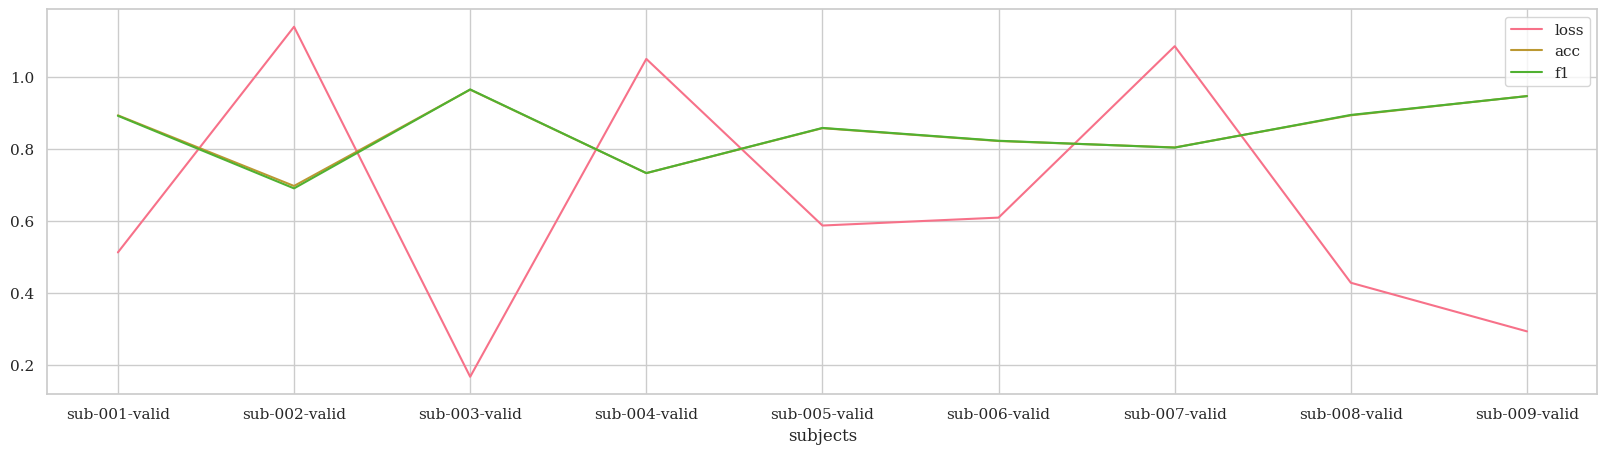

In [ ]:
import matplotlib.pyplot as plt

# validation metrics
valid_df = metrics_df[metrics_df['subjects'].str.contains('valid')]

plt.figure(figsize=(20, 5))
ax = plt.gca()
valid_df.plot(kind='line', x='subjects', y='loss', ax=ax)
valid_df.plot(kind='line', x='subjects', y='acc', ax=ax)
valid_df.plot(kind='line', x='subjects', y='f1', ax=ax)

plt.show()

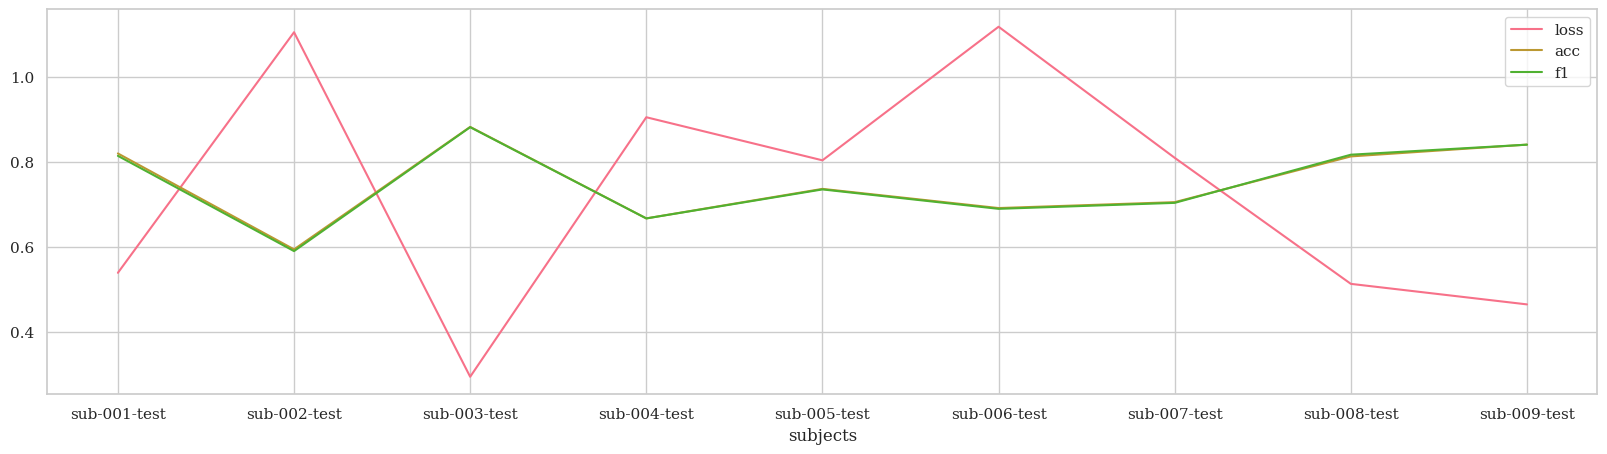

In [ ]:
# test metrics
test_df = metrics_df[metrics_df['subjects'].str.contains('test')]

plt.figure(figsize=(20, 5))
ax = plt.gca()
test_df.plot(kind='line', x='subjects', y='loss', ax=ax)
test_df.plot(kind='line', x='subjects', y='acc', ax=ax)
test_df.plot(kind='line', x='subjects', y='f1', ax=ax)

plt.show()

The two graphs above clearly demonstrate intersubject variablity, as the performance of the same model varies accross different subjects. Additionally, there appears to be variation in model performance between sessions (i.e., train vs. test), with better performance observed during the train session. This discrepancy suggests a potential overfitting issue.

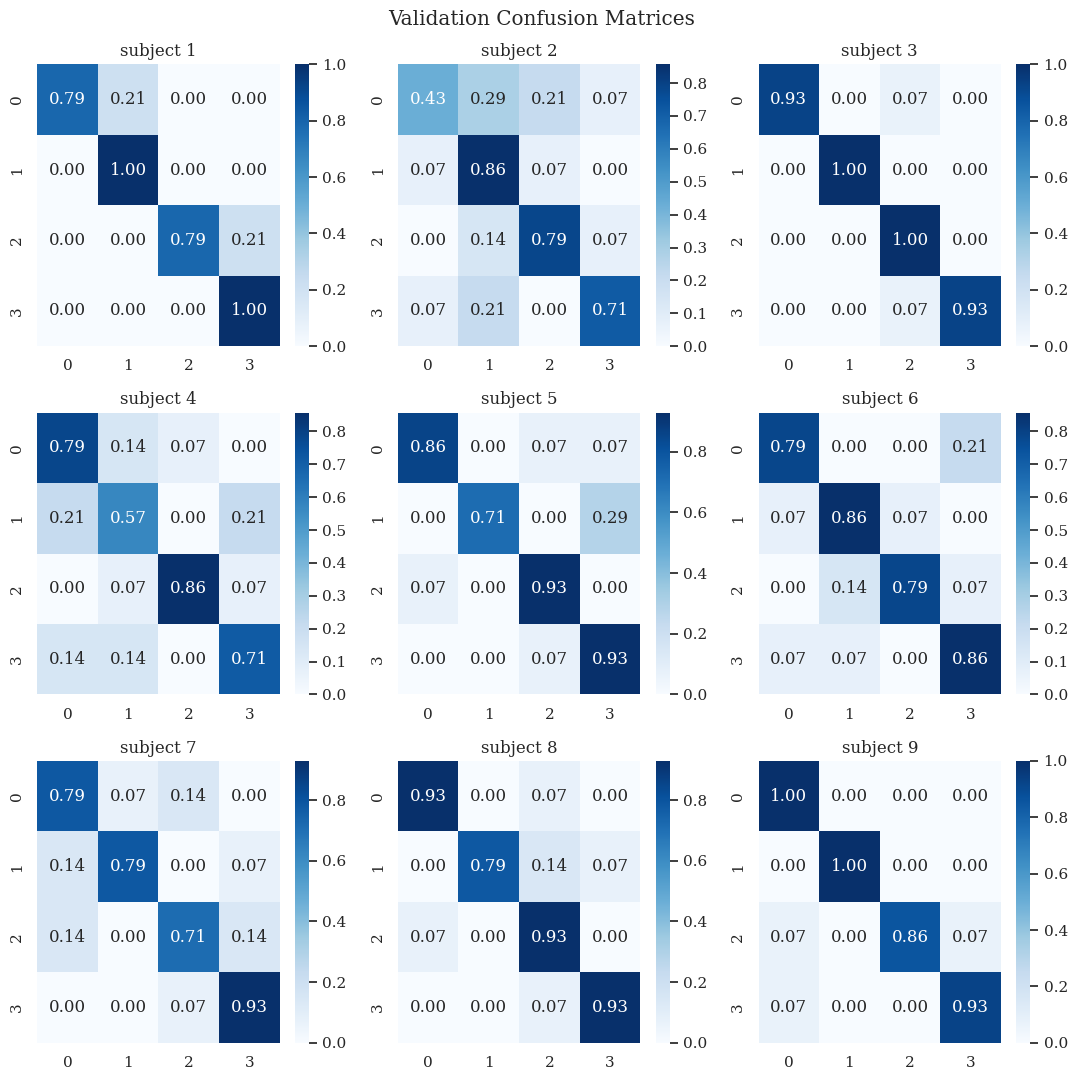

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# rows and cols for subplots
num_rows = 3
num_cols = 3

fig, axes = plt.subplots(num_rows, num_cols, figsize=(11, 11))
axes = axes.flatten()

for i, confusion_matrix in enumerate(valid_df['cm']):
  confusion_matrix_normalized = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)
  sns.heatmap(confusion_matrix_normalized,
              annot=True,
              fmt='.2f',
              cmap='Blues',
              ax=axes[i])
  axes[i].set_title(f'subject {i+1}')

fig.suptitle('Validation Confusion Matrices')
plt.tight_layout()
plt.show()

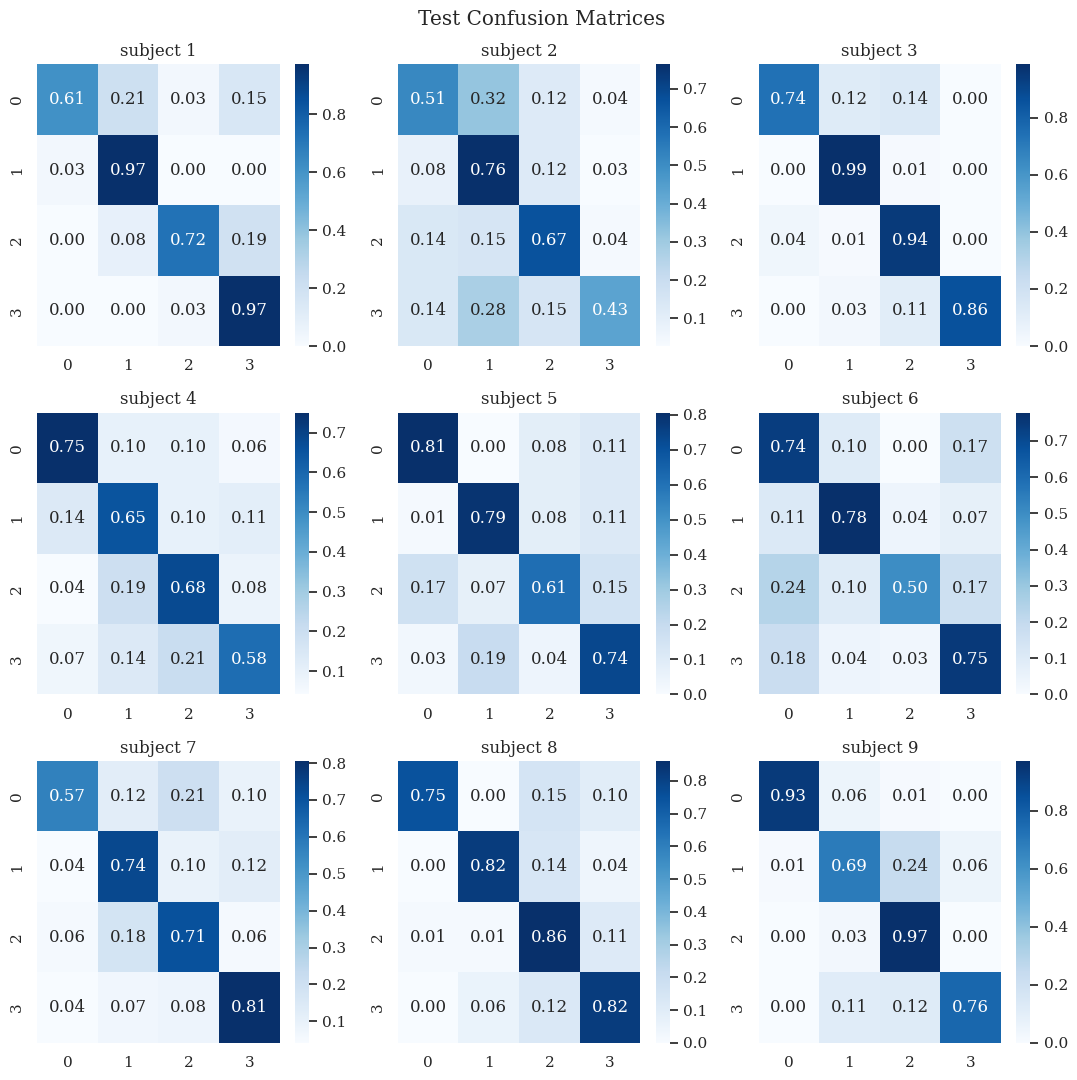

In [ ]:
# rows and cols for subplots
num_rows = 3
num_cols = 3

fig, axes = plt.subplots(num_rows, num_cols, figsize=(11, 11))
axes = axes.flatten()

for i, confusion_matrix in enumerate(test_df['cm']):
  confusion_matrix_normalized = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)
  sns.heatmap(confusion_matrix_normalized,
              annot=True,
              fmt='.2f',
              cmap='Blues',
              ax=axes[i])
  axes[i].set_title(f'subject {i+1}')

fig.suptitle('Test Confusion Matrices')
plt.tight_layout()
plt.show()

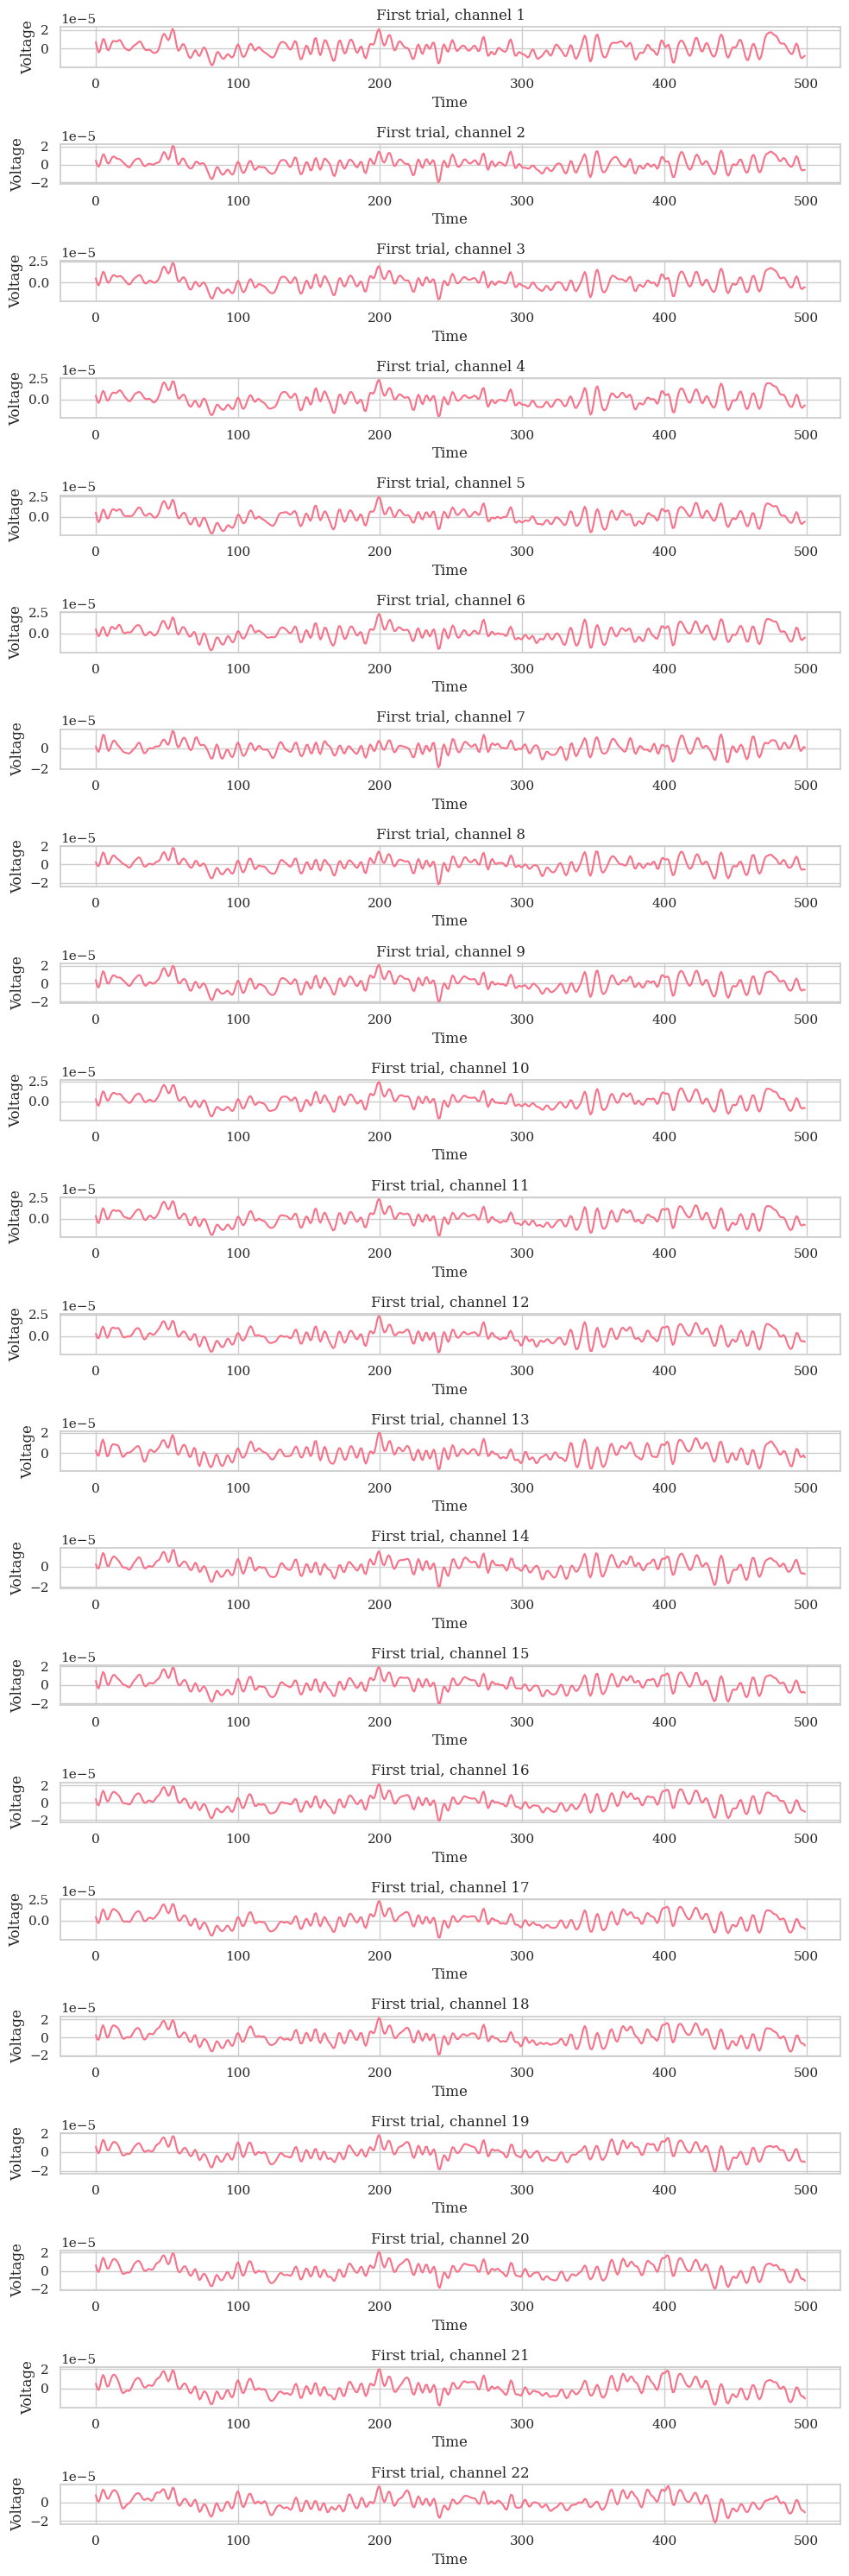

In [ ]:
# make sure that the code cells in "Train the model on a single cross-validation fold" have been run
subject_2_path = '/content/data/MOABB_pickled/BNCI2014-001/0125_0.18-21.9/sub-002.pkl'

with open(subject_2_path, 'rb') as f:
    sub_2_data = pkl.load(f)

X, y, y_labels = sub_2_data['x'], sub_2_data['y'], sub_2_data['labels']

num_trials   = X.shape[0]
num_channels = X.shape[1]

fig, axs = plt.subplots(nrows=22, figsize=(10, 30))

# Plot the time series for each channel
for i in range(num_channels):
    axs[i].plot(X[0, i])
    axs[i].set_title(f'First trial, channel {i+1}')
    axs[i].set_xlabel('Time')
    axs[i].set_ylabel('Voltage')

# Show the plot
plt.tight_layout()
plt.show()

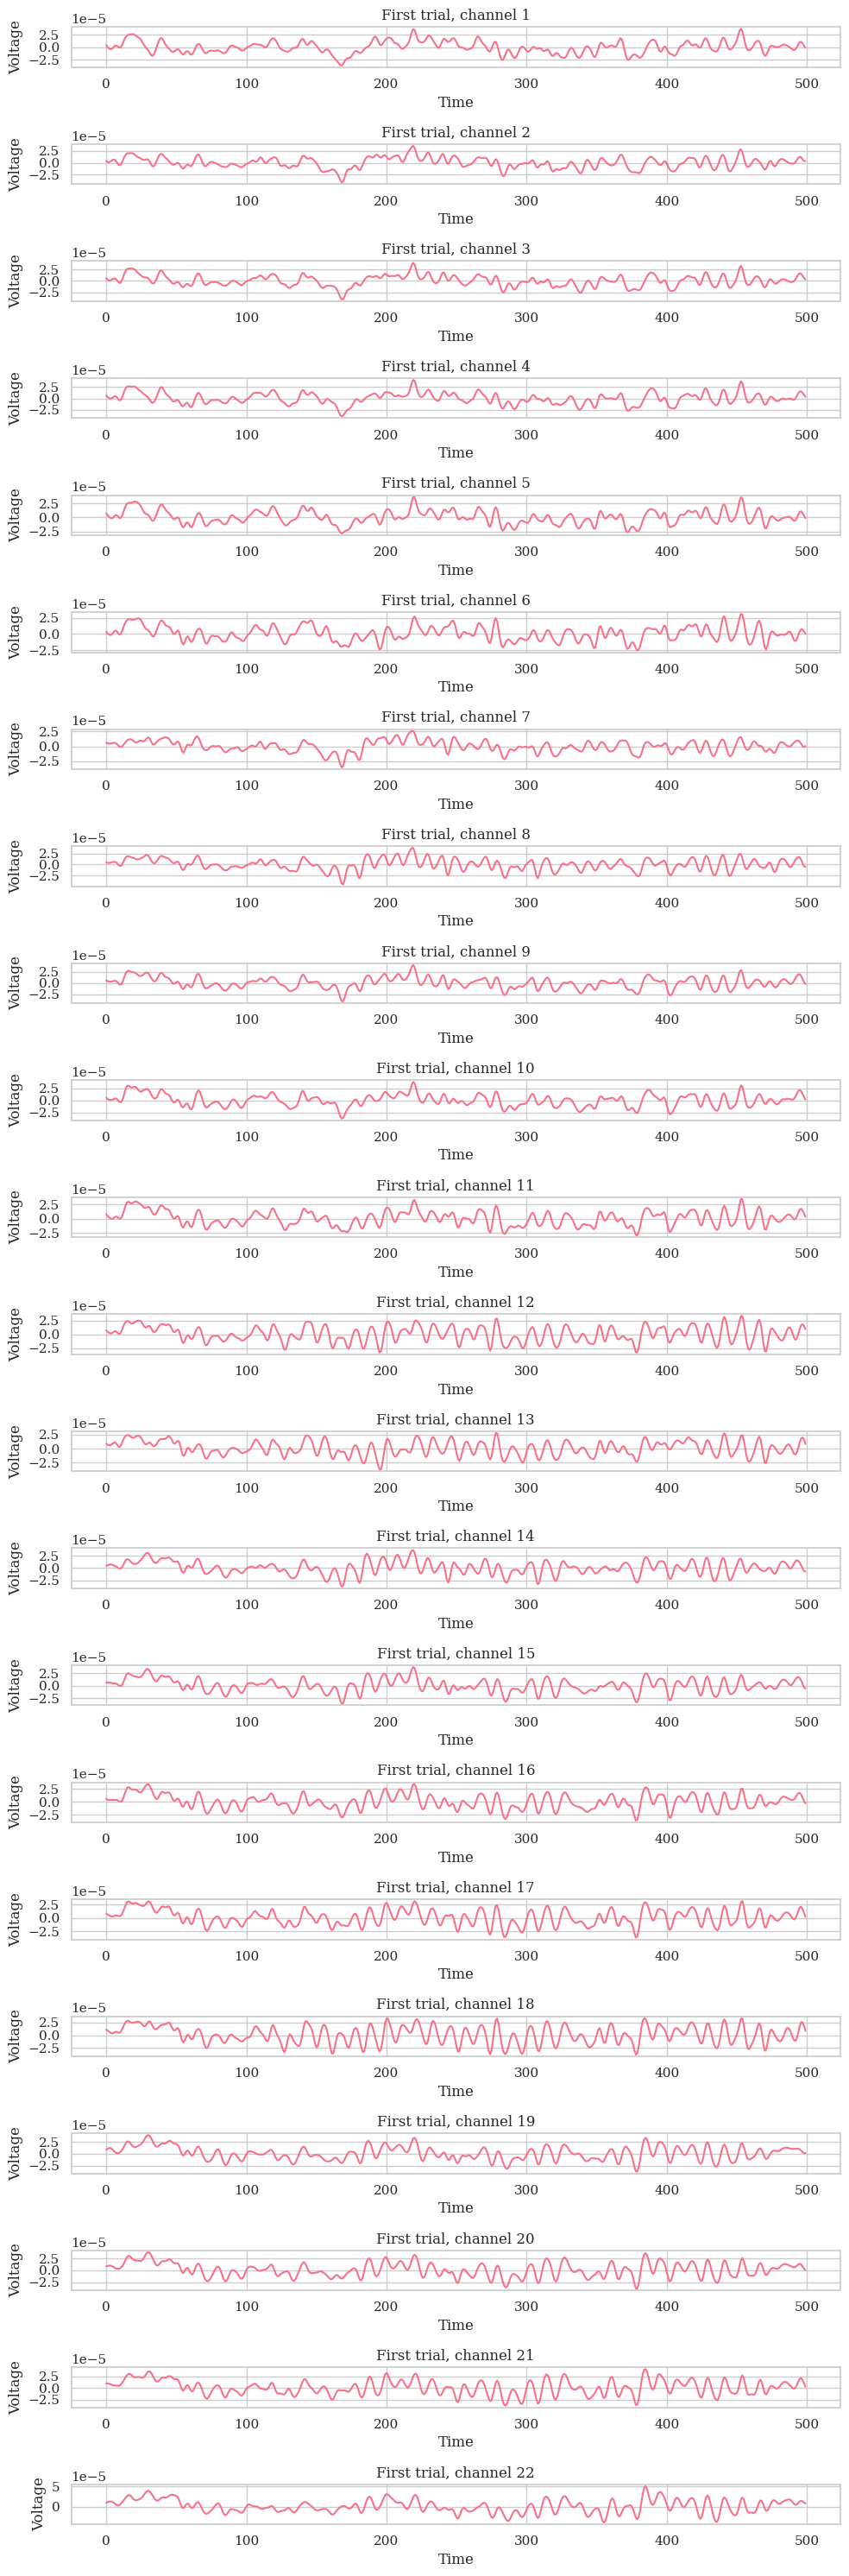

In [ ]:
subject_9_path = '/content/data/MOABB_pickled/BNCI2014-001/0125_0.18-21.9/sub-009.pkl'

with open(subject_9_path, 'rb') as f:
    sub_9_data = pkl.load(f)

X, y, y_labels = sub_9_data['x'], sub_9_data['y'], sub_9_data['labels']

num_trials   = X.shape[0]
num_channels = X.shape[1]

fig, axs = plt.subplots(nrows=22, figsize=(10, 30))

# Plot the time series for each channel
for i in range(num_channels):
    axs[i].plot(X[0, i])
    axs[i].set_title(f'First trial, channel {i+1}')
    axs[i].set_xlabel('Time')
    axs[i].set_ylabel('Voltage')

# Show the plot
plt.tight_layout()
plt.show()

From the plots above, it can be seen that the data for subject 2 seems "noisier" than that for subject 9. This disparity in data quality could contribute to the noticeable difference in performance observed between these two subjects.  

### Final words on the main model

In [ ]:
# print the aggregated result of 10 runs
with open('/content/speechbrain_moabb_project/results/10_run_results/results/full-experiment/BNCI2014001/aggregated_performance.txt', 'r') as file:
    print(file.read())

# log files can be found in this folder /content/speechbrain_moabb_project/results/10_run_results/results/full-experiment/BNCI2014001



---- leave-one-session-out ----

0train acc [0.763100 0.777800 0.762700 0.750800 0.755800 0.764700 0.742300 0.753900 0.754200 0.752700] avg: 0.757800 ± 0.009204 
1test acc [0.743100 0.749600 0.739200 0.750000 0.743100 0.748100 0.726900 0.746500 0.734600 0.728400] avg: 0.740950 ± 0.008039 


Aggregated results

acc [0.753086 0.763696 0.750965 0.750386 0.749421 0.756366 0.734568 0.750193 0.744406 0.740548] avg: 0.749363 ± 0.007706 
[{'name': 'objective', 'type': 'objective', 'value': 0.250636574074074}]



While satisfactory performance is attained across all subjects by the model, there is still room for potential improvement with further optimization (e.g. tuning other hyperparameters on top of the ones that have already been tuned, different settings for hyperparameter search, etc.). It is important to acknowledge, however, that these optimization endeavors were not investigated due to a lack of computational resources. Despite such a limitation, optimism regarding the potential for further enhancement of the model's capabilities persists.

## Other Models

Other models can be found in the speechbrain_moabb_project/models/not_tuned/ folder. Please keep in mind that due to limited computational resources, none of these models have been fully explored. Nevertheless, it is still worthwhile to discuss them, as there may be untapped potential that has yet to be discovered.

**Extra model 1: 5-branched EEGNetFusion**
- It is a natural extension of the original EEGNetFusion. Instead of having 3 branches, this model has 5 different EEGNet branches, which could mean even better generalization and performance. However, it raises the question of the optimal number of EEGNet branches, if such an optimal number exists. Initial results from training and testing the model proposed by Chowdhury et al. [4] did not quite achieve the same level of performance reported in their paper, similar to the case with Altuwaijri et al. As a result, it remains to be seen whether or not this is a viable model in this particular context (i.e. trained and tested with BNCI2014001).

**Extra model 2: Multi-branched ShallowConvNet (MBShallowConvNet)**
- Similar to EEGNetFusion, this model leverages the multibranched model architecture. Instead of EEGNet, each branch is now a ShallowConvNet. Conceptually, ShallowConvNet is much simpler than EEGNet as it is essentially a run-of-the-mill CNN. In spite of this, it has been found that the number of learnable parameters of ShallowConvNet greatly exceeds that of EEGNet [5]. Consequently, a multi-branched version of ShallowConvNet would require exponentially more paramters to train compared to EEGNetFusion. With that said, due its simplicity, it still remains a fascinating model design to look into. Altuwaijri et al. used this same model architecture in their paper, reporting similar results between their EEGNetFusion model (referred to as MBEEGNet) and their MBShallowConvNet model [3].

**Extra model 3: DeepConvNet**
- It is essentially a bigger ShallowConvNet with a couple more convolutional layers. Again, from a design standpoint, it is very simple and easy to implement. However, its number of learnable parameters exceeds even that of ShallowConvNet, which is not surprising considering that it has more convolutional layers [5]. Following the main theme of this report, it is entirely possible to make a multi-branched DeepConvNet.

As stated in the opening statement of this section, none of these models have undergone thorough investigation, namely hyperparams optimization. Initial testing revealed that all three models performed similarly, but fell short of achieving the performance level observed with the EEGNet model.


In [ ]:
depthconvnet_arch_path = '/content/speechbrain_moabb_project/my_models/not_tuned/DeepConvNet/architecture.txt'

with open(depthconvnet_arch_path, 'r') as file:
    print(file.read())

Layer (type:depth-idx)                   Output Shape              Param #
DeepConvNet                              [1, 4]                    --
├─Sequential: 1-1                        [1, 1, 1, 200]            --
│    └─Conv2d: 2-1                       [1, 491, 17, 25]          --
│    │    └─Conv2d: 3-1                  [1, 25, 491, 17]          250
│    └─Conv2d: 2-2                       [1, 491, 1, 25]           --
│    │    └─Conv2d: 3-2                  [1, 25, 491, 1]           10,625
│    └─BatchNorm2d: 2-3                  [1, 491, 1, 25]           --
│    │    └─BatchNorm2d: 3-3             [1, 25, 1, 491]           50
│    └─ELU: 2-4                          [1, 491, 1, 25]           --
│    └─Pooling2d: 2-5                    [1, 163, 1, 25]           --
│    │    └─MaxPool2d: 3-4               [1, 25, 163, 1]           --
│    └─Dropout: 2-6                      [1, 163, 1, 25]           --
│    └─Conv2d: 2-7                       [1, 154, 1, 50]           --
│    │    

In [ ]:
mbshallowconvnet_arch_path = '/content/speechbrain_moabb_project/my_models/not_tuned/MBShallowConvNet/architecture.txt'

with open(mbshallowconvnet_arch_path, 'r') as file:
    print(file.read())

Layer (type:depth-idx)                   Output Shape              Param #
MBShallowConvNet                         [1, 4]                    --
├─Sequential: 1-1                        [1, 116]                  --
│    └─Conv2d: 2-1                       [1, 496, 17, 4]           --
│    │    └─Conv2d: 3-1                  [1, 4, 496, 17]           24
│    └─Conv2d: 2-2                       [1, 496, 1, 4]            --
│    │    └─Conv2d: 3-2                  [1, 4, 496, 1]            272
│    └─BatchNorm2d: 2-3                  [1, 496, 1, 4]            --
│    │    └─BatchNorm2d: 3-3             [1, 4, 1, 496]            8
│    └─Square: 2-4                       [1, 496, 1, 4]            --
│    └─Pooling2d: 2-5                    [1, 29, 1, 4]             --
│    │    └─AvgPool2d: 3-4               [1, 4, 29, 1]             --
│    └─Log: 2-6                          [1, 29, 1, 4]             --
│    └─Dropout: 2-7                      [1, 29, 1, 4]             --
│    └─Flatten:

## References

In [ ]:
# [1]
# Professor Mirco Ravanelli's SpeechBrain
# @misc{speechbrain,
#   title={{SpeechBrain}: A General-Purpose Speech Toolkit},
#   author={Mirco Ravanelli and Titouan Parcollet and Peter Plantinga and Aku Rouhe and Samuele Cornell and Loren Lugosch and Cem Subakan and Nauman Dawalatabad and Abdelwahab Heba and Jianyuan Zhong and Ju-Chieh Chou and Sung-Lin Yeh and Szu-Wei Fu and Chien-Feng Liao and Elena Rastorgueva and François Grondin and William Aris and Hwidong Na and Yan Gao and Renato De Mori and Yoshua Bengio},
#   year={2021},
#   eprint={2106.04624},
#   archivePrefix={arXiv},
#   primaryClass={eess.AS},
#   note={arXiv:2106.04624}
# }

In [ ]:
# [2]
# EEGNetFusion (3 branches)
# @Article{computers9030072,
#   AUTHOR = {Roots, Karel and Muhammad, Yar and Muhammad, Naveed},
#   TITLE = {Fusion Convolutional Neural Network for Cross-Subject EEG Motor Imagery Classification},
#   JOURNAL = {Computers},
#   VOLUME = {9},
#   YEAR = {2020},
#   NUMBER = {3},
#   ARTICLE-NUMBER = {72},
#   URL = {https://www.mdpi.com/2073-431X/9/3/72},
#   ISSN = {2073-431X},
#   ABSTRACT = {Brain–computer interfaces (BCIs) can help people with limited motor abilities to interact with their environment without external assistance. A major challenge in electroencephalogram (EEG)-based BCI development and research is the cross-subject classification of motor imagery data. Due to the highly individualized nature of EEG signals, it has been difficult to develop a cross-subject classification method that achieves sufficiently high accuracy when predicting the subject’s intention. In this study, we propose a multi-branch 2D convolutional neural network (CNN) that utilizes different hyperparameter values for each branch and is more flexible to data from different subjects. Our model, EEGNet Fusion, achieves 84.1% and 83.8% accuracy when tested on the 103-subject eegmmidb dataset for executed and imagined motor actions, respectively. The model achieved statistically significantly higher results compared with three state-of-the-art CNN classifiers: EEGNet, ShallowConvNet, and DeepConvNet. However, the computational cost of the proposed model is up to four times higher than the model with the lowest computational cost used for comparison.},
#   DOI = {10.3390/computers9030072}
# }

In [ ]:
# [3]
# MBEEGNet/MBShallowConvNet
# @Article{bios12010022,
#   AUTHOR = {Altuwaijri, Ghadir Ali and Muhammad, Ghulam},
#   TITLE = {A Multibranch of Convolutional Neural Network Models for Electroencephalogram-Based Motor Imagery Classification},
#   JOURNAL = {Biosensors},
#   VOLUME = {12},
#   YEAR = {2022},
#   NUMBER = {1},
#   ARTICLE-NUMBER = {22},
#   URL = {https://www.mdpi.com/2079-6374/12/1/22},
#   PubMedID = {35049650},
#   ISSN = {2079-6374},
#   ABSTRACT = {Automatic high-level feature extraction has become a possibility with the advancement of deep learning, and it has been used to optimize efficiency. Recently, classification methods for Convolutional Neural Network (CNN)-based electroencephalography (EEG) motor imagery have been proposed, and have achieved reasonably high classification accuracy. These approaches, however, use the CNN single convolution scale, whereas the best convolution scale varies from subject to subject. This limits the precision of classification. This paper proposes multibranch CNN models to address this issue by effectively extracting the spatial and temporal features from raw EEG data, where the branches correspond to different filter kernel sizes. The proposed method’s promising performance is demonstrated by experimental results on two public datasets, the BCI Competition IV 2a dataset and the High Gamma Dataset (HGD). The results of the technique show a 9.61% improvement in the classification accuracy of multibranch EEGNet (MBEEGNet) from the fixed one-branch EEGNet model, and 2.95% from the variable EEGNet model. In addition, the multibranch ShallowConvNet (MBShallowConvNet) improved the accuracy of a single-scale network by 6.84%. The proposed models outperformed other state-of-the-art EEG motor imagery classification methods.},
#   DOI = {10.3390/bios12010022}
# }

In [ ]:
# [4]
# EEGNetFusionV2 (5 branches)
# @Article{s23187908,
#   AUTHOR = {Chowdhury, Radia Rayan and Muhammad, Yar and Adeel, Usman},
#   TITLE = {Enhancing Cross-Subject Motor Imagery Classification in EEG-Based Brain–Computer Interfaces by Using Multi-Branch CNN},
#   JOURNAL = {Sensors},
#   VOLUME = {23},
#   YEAR = {2023},
#   NUMBER = {18},
#   ARTICLE-NUMBER = {7908},
#   URL = {https://www.mdpi.com/1424-8220/23/18/7908},
#   PubMedID = {37765965},
#   ISSN = {1424-8220},
#   ABSTRACT = {A brain–computer interface (BCI) is a computer-based system that allows for communication between the brain and the outer world, enabling users to interact with computers using neural activity. This brain signal is obtained from electroencephalogram (EEG) signals. A significant obstacle to the development of BCIs based on EEG is the classification of subject-independent motor imagery data since EEG data are very individualized. Deep learning techniques such as the convolutional neural network (CNN) have illustrated their influence on feature extraction to increase classification accuracy. In this paper, we present a multi-branch (five branches) 2D convolutional neural network that employs several hyperparameters for every branch. The proposed model achieved promising results for cross-subject classification and outperformed EEGNet, ShallowConvNet, DeepConvNet, MMCNN, and EEGNet_Fusion on three public datasets. Our proposed model, EEGNet Fusion V2, achieves 89.6% and 87.8% accuracy for the actual and imagined motor activity of the eegmmidb dataset and scores of 74.3% and 84.1% for the BCI IV-2a and IV-2b datasets, respectively. However, the proposed model has a bit higher computational cost, i.e., it takes around 3.5 times more computational time per sample than EEGNet_Fusion.},
#   DOI = {10.3390/s23187908}
# }

In [ ]:
# [5]
# Original EEGNet/ShallowConvNet/DeepConvNet
# @article{Lawhern_2018,
#    title={EEGNet: a compact convolutional neural network for EEG-based brain–computer interfaces},
#    volume={15},
#    ISSN={1741-2552},
#    url={http://dx.doi.org/10.1088/1741-2552/aace8c},
#    DOI={10.1088/1741-2552/aace8c},
#    number={5},
#    journal={Journal of Neural Engineering},
#    publisher={IOP Publishing},
#    author={Lawhern, Vernon J and Solon, Amelia J and Waytowich, Nicholas R and Gordon, Stephen M and Hung, Chou P and Lance, Brent J},
#    year={2018},
#    month=jul, pages={056013} }
